In [ ]:
### 
    # This code is to plot the FigureS1 (Map of observing stations enclosed in the maximum permafrost extent).
    # Station data comes from "../../Data/Ts_seasonal_sensitivity/", calculated by "../Process/05*.py".
    # The permafrost probability in the figure comes from "../Data/Probability_pf/", calculated by "../Process/03*.py".
    # Also, this code counts the number of stations at each layer and the total number of stations.
###

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings("ignore")
# Matplotlib and Proplot 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import proplot as pplt
# Cartopy 
import cartopy.crs as ccrs

In [3]:
depths = ['160cm','240cm','320cm']
model_order = ["CESM2","CESM2-FV2","CESM2-WACCM","CNRM-CM6-1-HR","CNRM-CM6-1","CNRM-ESM2-1","E3SM-1-1","FGOALS-f3-L","FGOALS-g3","GFDL-CM4","GFDL-ESM4","MIROC6","MIROC-ES2L","MPI-ESM1-2-HR","MPI-ESM1-2-LR","NorESM2-LM","NorESM2-MM","TaiESM1","obs_Ts_Ts02"]
file_path = "../Data/Ts_seasonal_sensitivity/"

pf_stations_years_16 = pd.read_csv(file_path + "Ts_Ts02_obs_NH45_18model_160cm_interpolated.csv")
pf_stations16 = pf_stations_years_16.groupby('station').mean().reset_index()
pf_stations16.sort_values(by='station', inplace=True)
print(len(pf_stations16))

pf_stations_years_24 = pd.read_csv(file_path + "Ts_Ts02_obs_NH45_18model_240cm_interpolated.csv")
pf_stations24 = pf_stations_years_24.groupby('station').mean().reset_index()
pf_stations24.sort_values(by='station', inplace=True)
print(len(pf_stations24))

pf_stations_years_32 = pd.read_csv(file_path + "Ts_Ts02_obs_NH45_18model_320cm_interpolated.csv")
pf_stations32 = pf_stations_years_32.groupby('station').mean().reset_index()
pf_stations32.sort_values(by='station', inplace=True)
print(len(pf_stations32))

# Combine stations of all depths
combined_df = pd.concat([pf_stations16, pf_stations24, pf_stations32])
# Remove duplicate 'station' values
unique_stations1 = combined_df['station'].drop_duplicates()

# Calculate the number of unique stations
num_unique_stations1 = unique_stations1.count()
print(f"Total unique stations: {num_unique_stations1}")

91
52
85
Total unique stations: 119


In [4]:
lat = np.linspace(45.25, 89.75, 90)
lon = np.linspace(0.25, 359.75, 720)
# Create mask_landsea
lon_grid, lat_grid = np.meshgrid(lon, lat)
shapefile_path = '/home/wangjx/Data/ne_110m_land/ne_110m_land.shp'
gdf = gpd.read_file(shapefile_path)
mask_landsea = np.zeros_like(lon_grid, dtype=bool)

for i in range(len(lat)):
    for j in range(len(lon)):
        lon_point = lon_grid[i, j]
        lat_point = lat_grid[i, j]

        # Determine whether the grid point is on land
        point = Point(lon_point, lat_point)
        is_on_land = False
        for geometry in gdf.geometry:
            if geometry.intersects(point):
                is_on_land = True
                break

        mask_landsea[i, j] = is_on_land

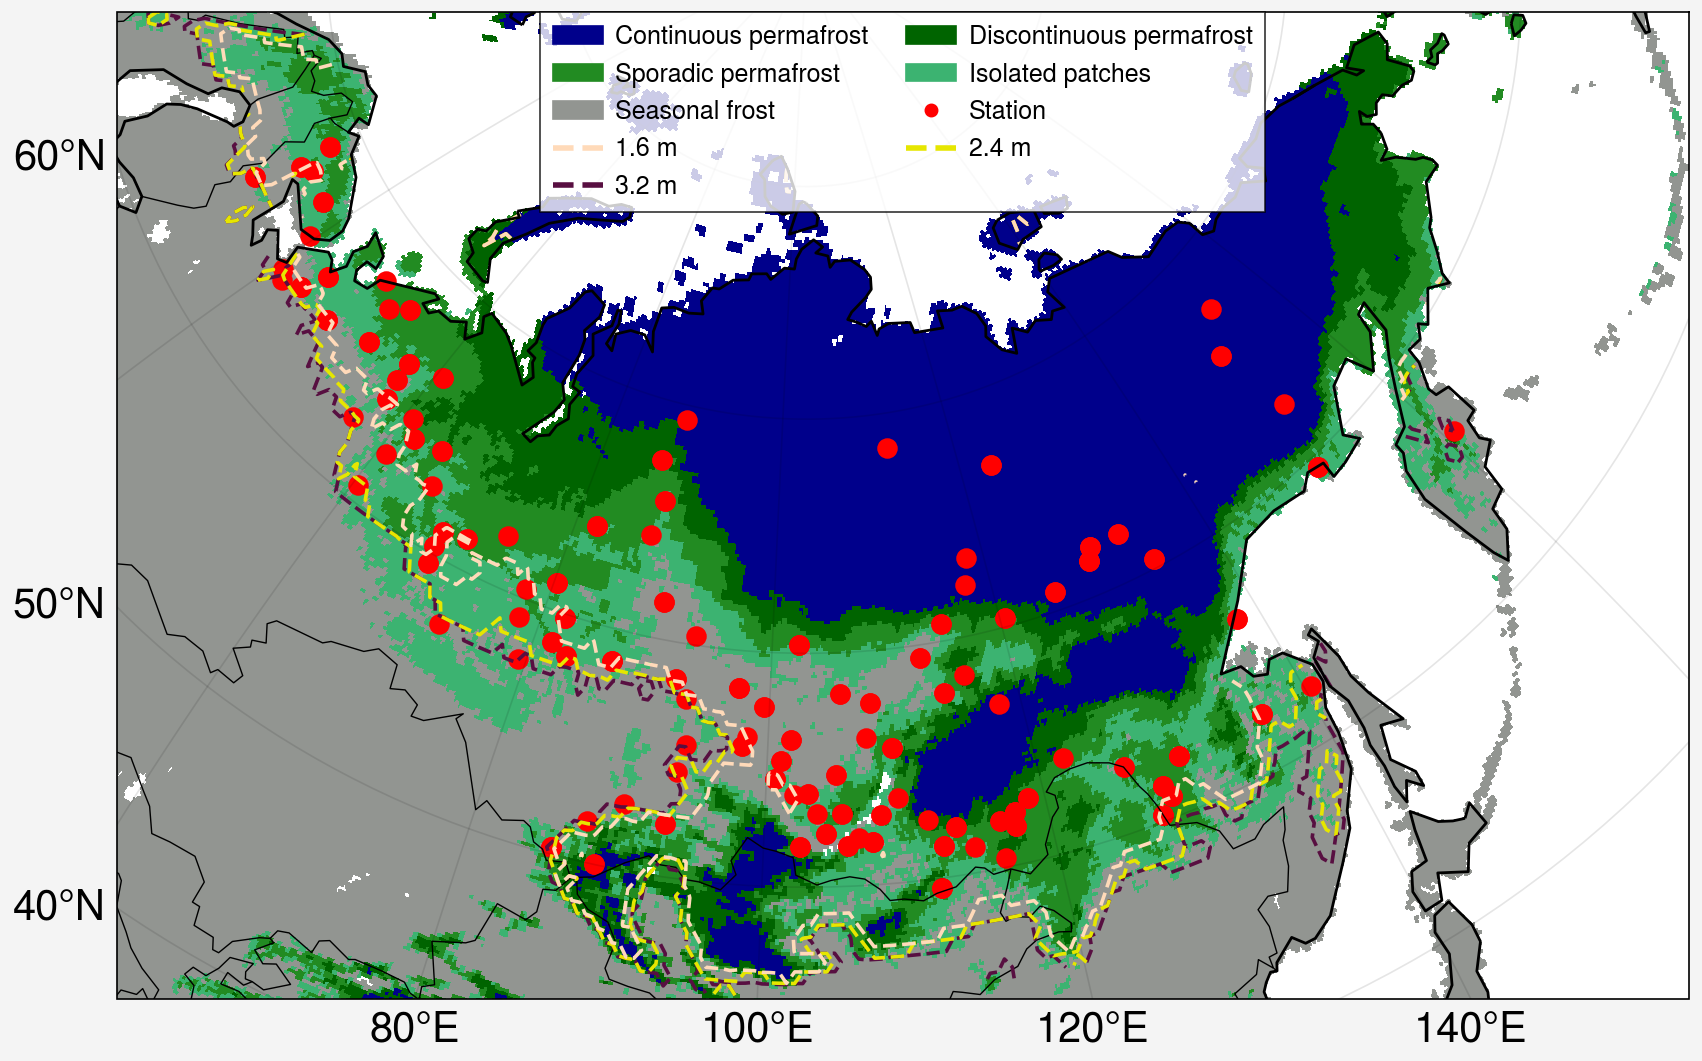

In [5]:
# Open TIF file from Obu et al.2019
tif_filename = '/home/wangjx/Data/Perprob_epsg3995.tif'  
tif_data = rxr.open_rasterio(tif_filename)
target_crs = 'EPSG:4326'
tif_data_reprojected = tif_data.rio.reproject(target_crs)

# Clip data to the Eurasia region
tif_data_clipped = tif_data_reprojected.rio.clip_box(minx=-180, miny=30, maxx=180, maxy=90)

# Define colormap and normalization
colors = ['grey','mediumseagreen','forestgreen','darkgreen', 'darkblue']
boundaries = [0, 0.01, 0.1, 0.5, 0.9, 1.01]
norm = BoundaryNorm(boundaries, len(colors))
cmap = ListedColormap(colors)

# Create plot
fig, ax = pplt.subplots(axwidth=8, proj='laea', proj_kw={'lon_0': 103, 'lat_0': 60})
pplt.rc.reso = 'lo'
ax.format(
    labels=True, gridlabelsize=15,
    lonlines=20, latlines=10, coast=True,
    gridminor=False, coastlinewidth=1, fontsize=10
)
ax.set_extent([58, 165, 45, 85], crs=ccrs.PlateCarree())

# Add national boundaries
shapefile_path = '/home/wangjx/Data/ne_110m_admin_0_boundary_lines_land/ne_110m_admin_0_boundary_lines_land.shp'
gdf = gpd.read_file(shapefile_path)
gdf.plot(ax=ax, edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())

# Plot the clipped TIF data
tif_data_clipped.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False)

# Define and plot contour lines
g = Dataset(f'../Data/Probability_pf/probability_lt_threshold_320.nc')
probability_lt_threshold = g['probability_lt_threshold'][:]

lon = np.linspace(0.25, 359.75, probability_lt_threshold.shape[1])
lat = np.linspace(45.25, 89.75, probability_lt_threshold.shape[0])
lon_grid, lat_grid = np.meshgrid(lon, lat)

probability_lt_threshold = np.where(~mask_landsea, np.nan, probability_lt_threshold)
ax.contour(lon_grid, lat_grid, probability_lt_threshold, levels=[0.01], colors='plum',
           linestyles='dashed', linewidths=1.3, transform=ccrs.PlateCarree())

g = Dataset(f'../Data/Probability_pf/probability_lt_threshold_240.nc')
probability_lt_threshold24 = g['probability_lt_threshold'][:]
probability_lt_threshold24 = np.where(~mask_landsea, np.nan, probability_lt_threshold24)
ax.contour(lon_grid, lat_grid, probability_lt_threshold24, levels=[0.01], colors='#E6E600',
            linestyles='dashed', linewidths=1.3, transform=ccrs.PlateCarree())

g = Dataset(f'../Data/Probability_pf/probability_lt_threshold_160.nc')
probability_lt_threshold16 = g['probability_lt_threshold'][:]
probability_lt_threshold16 = np.where(~mask_landsea, np.nan, probability_lt_threshold16)
ax.contour(lon_grid, lat_grid, probability_lt_threshold16, levels=[0.01], colors='peachpuff',
            linestyles='dashed', linewidths=1.3, transform=ccrs.PlateCarree())

# Scatter plot for stations
ax.scatter(combined_df['Lon'], combined_df['Lat'], s=46, color='red', marker='o', transform=ccrs.PlateCarree())

# Define legend
legend_patches = [
    Patch(color='darkblue', label='Continuous permafrost'), Patch(color='darkgreen', label='Discontinuous permafrost'),
    Patch(color='forestgreen', label='Sporadic permafrost'), Patch(color='mediumseagreen', label='Isolated patches'),

    Patch(color='grey', label='Seasonal frost'),
    Line2D([0], [0], color='red', marker='o', linestyle='None', markersize=4, label='Station'),
    Line2D([0], [0], color='peachpuff', linestyle='--', linewidth=2, label='1.6 m'),
    Line2D([0], [0], color='#E6E600', linestyle='--', linewidth=2, label='2.4 m'),
    Line2D([0], [0], color='plum', linestyle='--', linewidth=2, label='3.2 m')

]
ax.legend(handles=legend_patches, loc='upper center', ncol=2, fontsize=10, frameon=True)

plt.show()

In [6]:
fig.savefig("../Figures/FigureS1.png", bbox_inches='tight',dpi=300)